In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.utils import ModelEmaV3 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import torch.optim as optim
import numpy as np
import os  


d:\anaconda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class SinusoidalEmbeddings(nn.Module):
    """
    使用正弦/余弦函数对时间步（timestep）进行位置编码，将离散的时间步 t 映射为连续的、具有周期性的高维向量。
    """
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        # 创建形状为 [time_steps, 1] 的时间步索引
        position = torch.arange(time_steps).unsqueeze(1).float()  

        # 计算频率缩放因子，用于控制不同维度的周期
        div = torch.exp(
            torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim)
        ) 

        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)        # 偶数维度用 sin 编码
        embeddings[:, 1::2] = torch.cos(position * div)      # 奇数维度用 cos 编码
        self.register_buffer('embeddings', embeddings)

    def forward(self, x, t):
        """
        根据输入的时间步索引 t，取出对应的时间嵌入向量，并调整形状以匹配特征图 x。
        """
        # 从预计算的 embeddings 表中取出 t 对应的嵌入向量
        embeds = self.embeddings[t].to(x.device)

        # 添加两个维度 (H=1, W=1)，变为 (B, embed_dim, 1, 1)
        # 这样在后续与特征图 x (B, C, H, W) 相加时，embeds 会自动广播到每个空间位置
        return embeds[:, :, None, None]

In [13]:
#残差网络， 带时间嵌入注入的残差块，使网络能根据当前时间步 t 调整去噪行为。
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x




In [14]:
#将输入特征图的每个空间位置视为一个 token，计算它们之间的全局依赖关系。
class Attention(nn.Module):
    def __init__(self, C: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C * 3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')#将空间维度展平为序列 
        x = self.proj1(x)#线性投影得到 Q, K, V 
        head_dim = x.shape[-1] // (3 * self.num_heads)# # 计算每个注意力头的维度
        
        x = rearrange(x, 'b L (K H C) -> K b H L C', K=3, H=self.num_heads, C=head_dim)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H L C -> b L (H C)')
        x = rearrange(x, 'b (h w) C -> b h w C', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')




In [15]:
#扩散模型的噪声调度器
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int = 1000):
        super().__init__()
         # beta_t 控制每一步添加的高斯噪声的方差
        self.register_buffer('beta', torch.linspace(1e-4, 0.02, num_time_steps))
        #alpha_t = 1 - beta_t
        alpha = 1.0 - self.beta
        self.register_buffer('alpha', torch.cumprod(alpha, dim=0))

    def forward(self, t):
        return self.beta[t], self.alpha[t]# 根据时间步索引 t，返回对应的 beta_t 和 alpha_bar_t。

# 设置随机种子。
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)






In [3]:
#UNet 架构中的一个基本层
class UnetLayer(nn.Module):
    def __init__(self, upscale: bool, attention: bool, num_groups: int, dropout_prob: float, num_heads: int, C: int):
        
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C // 2, kernel_size=4, stride=2, padding=1) # 上采样：使用转置卷积
        else:
            self.conv = nn.Conv2d(C, C * 2, kernel_size=3, stride=2, padding=1)# 下采样：使用普通卷积，通道数翻倍
            
            
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
      
        x = self.ResBlock1(x, embeddings)
        
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
            
        x = self.ResBlock2(x, embeddings)
        
        return self.conv(x), x


In [16]:
class UNET(nn.Module):
    def __init__(self,
                 Channels: List = [64, 128, 256, 512, 512, 384],
                 Attentions: List = [False, True, False, False, False, True],
                 Upscales: List = [False, False, False, True, True, True],
                 num_groups: int = 32,
                 dropout_prob: float = 0.1,
                 num_heads: int = 8,
                 input_channels: int = 1,
                 output_channels: int = 1,
                 time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1] // 2) + Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        # Encoder
        for i in range(self.num_layers // 2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        # Decoder
        for i in range(self.num_layers // 2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, _ = layer(x, embeddings)
            x = torch.cat((x, residuals[self.num_layers - i - 1]), dim=1)
        x = self.late_conv(x)
        x = self.relu(x)
        return self.output_conv(x)



In [17]:


def train(batch_size: int = 64,
          num_time_steps: int = 1000,
          num_epochs: int = 15,
          seed: int = -1,
          ema_decay: float = 0.9999,
          lr=2e-5,
          checkpoint_path: str = None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps).cuda()  
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)

    # 如果是继续训练，才加载 checkpoint
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    criterion = nn.MSELoss(reduction='mean')

    for epoch in range(num_epochs):
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for x, _ in pbar:
            x = x.cuda()
            x = F.pad(x, (2, 2, 2, 2))  # 28x28 -> 32x32
            t = torch.randint(0, num_time_steps, (x.shape[0],), device=x.device)
            e = torch.randn_like(x)
            alpha_t = scheduler.alpha[t].view(-1, 1, 1, 1)
            x_noisy = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * e

            pred_noise = model(x_noisy, t)
            loss = criterion(pred_noise, e)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.update(model)

            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1} | Avg Loss: {avg_loss:.5f}')

    # 保存模型
    os.makedirs('checkpoints', exist_ok=True)
    checkpoint = {
        'weights': model.state_dict(),
        'ema': ema.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    save_path = 'checkpoints/ddpm_checkpoint.pth'
    torch.save(checkpoint, save_path)
    print(f"Model saved to {save_path}")




In [18]:

def display_reverse(images: List):
    if len(images) > 10:
        images = images[:10]
    fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))
    if len(images) == 1:
        axes = [axes]
    for ax, img in zip(axes, images):
        img = img.squeeze(0).cpu().numpy()
        if img.shape[0] == 1:
            img = img[0]
        img = np.clip(img, 0, 1)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def inference(checkpoint_path: str = 'checkpoints/ddpm_checkpoint.pth',
              num_time_steps: int = 1000,
              ema_decay: float = 0.9999):
    assert os.path.exists(checkpoint_path), f"Checkpoint not found: {checkpoint_path}"
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    model = ema.module.eval()

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps).cuda()  # ← 也加 .cuda()
    times_to_show = [999, 700, 550, 400, 300, 200, 100, 50, 15, 0]

    with torch.no_grad():
        x_t = torch.randn(1, 1, 32, 32).cuda()
        images = []

        for t in reversed(range(num_time_steps)):
            t_batch = torch.tensor([t], device=x_t.device)
            beta_t = scheduler.beta[t]
            alpha_t = scheduler.alpha[t]
            alpha_prev = scheduler.alpha[t-1] if t > 0 else torch.tensor(1.0)

            pred_noise = model(x_t, t_batch)

            # 计算 x_{t-1}
            coef1 = 1.0 / torch.sqrt(1.0 - beta_t)
            coef2 = beta_t / torch.sqrt(1.0 - alpha_t)
            x0_pred = (x_t - torch.sqrt(1.0 - alpha_t) * pred_noise) / torch.sqrt(alpha_t)
            mean = coef1 * (x_t - coef2 * pred_noise)

            if t > 0:
                sigma_t = torch.sqrt(beta_t * (1.0 - alpha_prev) / (1.0 - alpha_t))
                noise = torch.randn_like(x_t)
                x_t = mean + sigma_t * noise
            else:
                x_t = mean

            if t in times_to_show:
                img = x_t.cpu().clone()
                images.append(img)

        # 显示结果
        display_reverse(images)




Epoch 1/70: 100%|██████████| 937/937 [00:35<00:00, 26.31it/s, loss=0.0791]


Epoch 1 | Avg Loss: 0.13652


Epoch 2/70: 100%|██████████| 937/937 [00:34<00:00, 27.21it/s, loss=0.0313]


Epoch 2 | Avg Loss: 0.05114


Epoch 3/70: 100%|██████████| 937/937 [00:34<00:00, 26.88it/s, loss=0.0352]


Epoch 3 | Avg Loss: 0.03842


Epoch 4/70: 100%|██████████| 937/937 [00:35<00:00, 26.37it/s, loss=0.0258]


Epoch 4 | Avg Loss: 0.03248


Epoch 5/70: 100%|██████████| 937/937 [00:36<00:00, 25.74it/s, loss=0.0297]


Epoch 5 | Avg Loss: 0.02929


Epoch 6/70: 100%|██████████| 937/937 [00:35<00:00, 26.68it/s, loss=0.0125]


Epoch 6 | Avg Loss: 0.02727


Epoch 7/70: 100%|██████████| 937/937 [00:35<00:00, 26.12it/s, loss=0.0198]


Epoch 7 | Avg Loss: 0.02507


Epoch 8/70: 100%|██████████| 937/937 [00:36<00:00, 25.93it/s, loss=0.0201]


Epoch 8 | Avg Loss: 0.02306


Epoch 9/70: 100%|██████████| 937/937 [00:34<00:00, 27.06it/s, loss=0.0195] 


Epoch 9 | Avg Loss: 0.02160


Epoch 10/70: 100%|██████████| 937/937 [00:35<00:00, 26.74it/s, loss=0.022]  


Epoch 10 | Avg Loss: 0.02038


Epoch 11/70: 100%|██████████| 937/937 [00:34<00:00, 27.24it/s, loss=0.0187] 


Epoch 11 | Avg Loss: 0.01912


Epoch 12/70: 100%|██████████| 937/937 [00:34<00:00, 27.32it/s, loss=0.0167] 


Epoch 12 | Avg Loss: 0.01845


Epoch 13/70: 100%|██████████| 937/937 [00:36<00:00, 26.02it/s, loss=0.0137] 


Epoch 13 | Avg Loss: 0.01791


Epoch 14/70: 100%|██████████| 937/937 [00:33<00:00, 27.97it/s, loss=0.0269] 


Epoch 14 | Avg Loss: 0.01715


Epoch 15/70: 100%|██████████| 937/937 [00:34<00:00, 27.09it/s, loss=0.0174] 


Epoch 15 | Avg Loss: 0.01685


Epoch 16/70: 100%|██████████| 937/937 [00:35<00:00, 26.74it/s, loss=0.0215] 


Epoch 16 | Avg Loss: 0.01651


Epoch 17/70: 100%|██████████| 937/937 [00:34<00:00, 26.96it/s, loss=0.019]  


Epoch 17 | Avg Loss: 0.01608


Epoch 18/70: 100%|██████████| 937/937 [00:34<00:00, 26.78it/s, loss=0.0183] 


Epoch 18 | Avg Loss: 0.01611


Epoch 19/70: 100%|██████████| 937/937 [00:36<00:00, 25.77it/s, loss=0.0131] 


Epoch 19 | Avg Loss: 0.01572


Epoch 20/70: 100%|██████████| 937/937 [00:34<00:00, 27.01it/s, loss=0.0168] 


Epoch 20 | Avg Loss: 0.01543


Epoch 21/70: 100%|██████████| 937/937 [00:34<00:00, 26.77it/s, loss=0.0163] 


Epoch 21 | Avg Loss: 0.01533


Epoch 22/70: 100%|██████████| 937/937 [00:35<00:00, 26.62it/s, loss=0.0172] 


Epoch 22 | Avg Loss: 0.01506


Epoch 23/70: 100%|██████████| 937/937 [00:33<00:00, 27.67it/s, loss=0.0181] 


Epoch 23 | Avg Loss: 0.01504


Epoch 24/70: 100%|██████████| 937/937 [00:34<00:00, 27.23it/s, loss=0.0197] 


Epoch 24 | Avg Loss: 0.01485


Epoch 25/70: 100%|██████████| 937/937 [00:33<00:00, 27.77it/s, loss=0.0159] 


Epoch 25 | Avg Loss: 0.01459


Epoch 26/70: 100%|██████████| 937/937 [00:36<00:00, 25.49it/s, loss=0.0145] 


Epoch 26 | Avg Loss: 0.01464


Epoch 27/70: 100%|██████████| 937/937 [00:36<00:00, 25.77it/s, loss=0.0146] 


Epoch 27 | Avg Loss: 0.01418


Epoch 28/70: 100%|██████████| 937/937 [00:32<00:00, 28.74it/s, loss=0.0144] 


Epoch 28 | Avg Loss: 0.01418


Epoch 29/70: 100%|██████████| 937/937 [00:37<00:00, 25.14it/s, loss=0.0184] 


Epoch 29 | Avg Loss: 0.01435


Epoch 30/70: 100%|██████████| 937/937 [00:36<00:00, 25.98it/s, loss=0.00969]


Epoch 30 | Avg Loss: 0.01390


Epoch 31/70: 100%|██████████| 937/937 [00:35<00:00, 26.38it/s, loss=0.0137] 


Epoch 31 | Avg Loss: 0.01379


Epoch 32/70: 100%|██████████| 937/937 [00:34<00:00, 27.04it/s, loss=0.0126] 


Epoch 32 | Avg Loss: 0.01368


Epoch 33/70: 100%|██████████| 937/937 [00:37<00:00, 24.88it/s, loss=0.0175] 


Epoch 33 | Avg Loss: 0.01387


Epoch 34/70: 100%|██████████| 937/937 [00:35<00:00, 26.25it/s, loss=0.0144] 


Epoch 34 | Avg Loss: 0.01387


Epoch 35/70: 100%|██████████| 937/937 [00:35<00:00, 26.55it/s, loss=0.0177] 


Epoch 35 | Avg Loss: 0.01370


Epoch 36/70: 100%|██████████| 937/937 [00:34<00:00, 27.05it/s, loss=0.0159] 


Epoch 36 | Avg Loss: 0.01352


Epoch 37/70: 100%|██████████| 937/937 [00:33<00:00, 27.85it/s, loss=0.0126] 


Epoch 37 | Avg Loss: 0.01344


Epoch 38/70: 100%|██████████| 937/937 [00:32<00:00, 28.56it/s, loss=0.012]  


Epoch 38 | Avg Loss: 0.01344


Epoch 39/70: 100%|██████████| 937/937 [00:31<00:00, 29.51it/s, loss=0.0173] 


Epoch 39 | Avg Loss: 0.01332


Epoch 40/70: 100%|██████████| 937/937 [00:33<00:00, 27.66it/s, loss=0.0113] 


Epoch 40 | Avg Loss: 0.01324


Epoch 41/70: 100%|██████████| 937/937 [00:36<00:00, 25.69it/s, loss=0.0193] 


Epoch 41 | Avg Loss: 0.01309


Epoch 42/70: 100%|██████████| 937/937 [00:34<00:00, 27.12it/s, loss=0.0118] 


Epoch 42 | Avg Loss: 0.01311


Epoch 43/70: 100%|██████████| 937/937 [00:33<00:00, 28.21it/s, loss=0.0132] 


Epoch 43 | Avg Loss: 0.01299


Epoch 44/70: 100%|██████████| 937/937 [00:33<00:00, 27.69it/s, loss=0.0172] 


Epoch 44 | Avg Loss: 0.01303


Epoch 45/70: 100%|██████████| 937/937 [00:33<00:00, 28.28it/s, loss=0.0103] 


Epoch 45 | Avg Loss: 0.01298


Epoch 46/70: 100%|██████████| 937/937 [00:33<00:00, 28.11it/s, loss=0.0137] 


Epoch 46 | Avg Loss: 0.01304


Epoch 47/70: 100%|██████████| 937/937 [00:32<00:00, 28.76it/s, loss=0.0142] 


Epoch 47 | Avg Loss: 0.01290


Epoch 48/70: 100%|██████████| 937/937 [00:34<00:00, 27.00it/s, loss=0.0177] 


Epoch 48 | Avg Loss: 0.01280


Epoch 49/70: 100%|██████████| 937/937 [00:34<00:00, 27.17it/s, loss=0.0192] 


Epoch 49 | Avg Loss: 0.01285


Epoch 50/70: 100%|██████████| 937/937 [00:32<00:00, 28.42it/s, loss=0.0108] 


Epoch 50 | Avg Loss: 0.01294


Epoch 51/70: 100%|██████████| 937/937 [00:34<00:00, 27.16it/s, loss=0.0113] 


Epoch 51 | Avg Loss: 0.01292


Epoch 52/70: 100%|██████████| 937/937 [00:35<00:00, 26.66it/s, loss=0.00907]


Epoch 52 | Avg Loss: 0.01276


Epoch 53/70: 100%|██████████| 937/937 [00:34<00:00, 26.99it/s, loss=0.0145] 


Epoch 53 | Avg Loss: 0.01275


Epoch 54/70: 100%|██████████| 937/937 [00:35<00:00, 26.51it/s, loss=0.00912]


Epoch 54 | Avg Loss: 0.01269


Epoch 55/70: 100%|██████████| 937/937 [00:36<00:00, 25.62it/s, loss=0.0104] 


Epoch 55 | Avg Loss: 0.01241


Epoch 56/70: 100%|██████████| 937/937 [00:35<00:00, 26.20it/s, loss=0.0148] 


Epoch 56 | Avg Loss: 0.01276


Epoch 57/70: 100%|██████████| 937/937 [00:34<00:00, 26.91it/s, loss=0.016]  


Epoch 57 | Avg Loss: 0.01260


Epoch 58/70: 100%|██████████| 937/937 [00:37<00:00, 25.10it/s, loss=0.013]  


Epoch 58 | Avg Loss: 0.01254


Epoch 59/70: 100%|██████████| 937/937 [00:33<00:00, 27.78it/s, loss=0.0135] 


Epoch 59 | Avg Loss: 0.01249


Epoch 60/70: 100%|██████████| 937/937 [00:34<00:00, 26.82it/s, loss=0.0154] 


Epoch 60 | Avg Loss: 0.01242


Epoch 61/70: 100%|██████████| 937/937 [00:35<00:00, 26.75it/s, loss=0.0141] 


Epoch 61 | Avg Loss: 0.01241


Epoch 62/70: 100%|██████████| 937/937 [00:34<00:00, 27.07it/s, loss=0.0159] 


Epoch 62 | Avg Loss: 0.01250


Epoch 63/70: 100%|██████████| 937/937 [00:32<00:00, 29.27it/s, loss=0.0117] 


Epoch 63 | Avg Loss: 0.01227


Epoch 64/70: 100%|██████████| 937/937 [00:35<00:00, 26.26it/s, loss=0.014]  


Epoch 64 | Avg Loss: 0.01243


Epoch 65/70: 100%|██████████| 937/937 [00:33<00:00, 27.72it/s, loss=0.014]  


Epoch 65 | Avg Loss: 0.01242


Epoch 66/70: 100%|██████████| 937/937 [00:34<00:00, 27.47it/s, loss=0.0125] 


Epoch 66 | Avg Loss: 0.01232


Epoch 67/70: 100%|██████████| 937/937 [00:36<00:00, 25.34it/s, loss=0.0148] 


Epoch 67 | Avg Loss: 0.01231


Epoch 68/70: 100%|██████████| 937/937 [00:36<00:00, 25.76it/s, loss=0.0132] 


Epoch 68 | Avg Loss: 0.01222


Epoch 69/70: 100%|██████████| 937/937 [00:32<00:00, 28.67it/s, loss=0.018]  


Epoch 69 | Avg Loss: 0.01209


Epoch 70/70: 100%|██████████| 937/937 [00:33<00:00, 27.66it/s, loss=0.0195] 


Epoch 70 | Avg Loss: 0.01228
Model saved to checkpoints/ddpm_checkpoint.pth


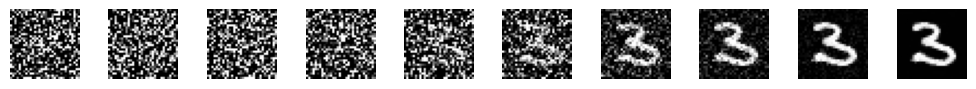

In [20]:

def main():
    train(
        batch_size=64,
        num_epochs=70,        
        lr=2e-5,              
        checkpoint_path=None  
    )
    # 训练完后自动推理
    inference('checkpoints/ddpm_checkpoint.pth')


if __name__ == '__main__':
    main()